# Importing necessary packages 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import scatter
import pylab
from matplotlib.colors import ListedColormap
import seaborn as sns
import squarify
import pathlib 
from pathlib import Path 
import re
import datetime as dt
from functools import reduce
import warnings; warnings.filterwarnings(action='once')
from pandas_profiling import ProfileReport

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

# Functions for Extracting, Writing, Transforming, Summarizing Data

In [2]:
# Extract the required file based on extension 
e_df={}
def read_files(file_path):
    '''
    input parameters: 
        path: path of the file 
        
        we can read the a file into a pandas data frame 
        
        we can extend the ability to read any file based on the extension 
        eg: parquet, json, Big Query, etc
        
        with pathlib we can also extend the functionality to OS subdirectories
    
    returns:
        None
    '''
    path= pathlib.Path(file_path)
    
    if path.suffix == '.csv':
        return pd.read_csv(file_path,sep = ',')
    elif path.suffix == '.txt':
        return pd.read_csv(file_path,delimiter = "\t")
    elif path.suffix == '.xlsx':
        xl = pd.ExcelFile(path)
        for sheet in xl.sheet_names:
            e_df[f'{sheet}']= pd.read_excel(xl,sheet_name=sheet)
            return None

#Write files back to the system
def write_files(df,file_path,file_name,file_format):
    '''
    input parameters: 
        file_path: path of the file
        file_name: name of the file
        file_format: format of the file we want to write
        
        we can write a pandas data frame into the file format we want
        
        we can extend the ability to write a data frame based on the extension 
        eg: parquet, json, sql, etc
    
    returns:
        None
    '''
    file = file_path+'/'+file_name+'.'+file_format
    
    if file_format == 'csv':
        df.to_csv(file,sep=',',index=False)
    if file_format == 'txt':
        df.to_csv(file,sep='\t',index=False)
    if file_format == 'xlsx':
        df.to_excel(file,sheet_name=file_name)
    return None

#helper function
def strip_whitespaces(row):
    '''
    input parameters: 
        row: Pandas Series 
        
        helper function that we can apply on all string columns
        to remove whitespaces
    
    returns:
        Pandas series with removed leading and trailing whitespaces
    '''
    return row.str.strip()

#Clean strings of a DataFrame
def clean_strings(df,fn):
    '''
    input parameters: 
        df: Pandas DataFrame
        fn: helper function that we can apply to all the rows
        
        retains only the string columns and applies the helper function,
        in our case that is removing white spaces
        
        we can extend the functionality to retain any type of columns to apply 
        a function to a number of rows 
    
    returns:
        Pandas DataFrame with removed leading and trailing whitespaces from all string
        columns
        Caution: This will only return a subset of original dataframe (string columns)
        not the entire data frame
        to replace existing firlds we should do the following
        df[['col1','col2','col3'..]] = clean_strings(df,fn)
    '''
    return df.select_dtypes(include=['object']).apply(fn,axis='columns')

def clean_column_names(df):
    '''
    input parameters: 
        df: Pandas DataFrame
        
        a list comprehension ith some string manipulation
        
    returns:
        None
    '''
    df.columns= [col.lower().strip().replace(' ','_') for col in df.columns]
    return None

#for playlist_uri
#splitting strings based on a seperator
def split_strings(string,splitby,index):
    '''
    input parameters: 
        string: a string value
        
        we split by specified seperator
        
    returns:
        string element from a list at specified position
    '''
    ls = string.split(splitby)
    return ls[index]

#helper function for apply, used in playlist tokens 
def split_to_rows(s):
    '''
    input parameters: 
        string: a string value

        
    returns:
        clean string
    '''
    return s.replace('[','').replace(']','').split(',')

#add datastamp to the dataset
def add_date_stamp(df,column_name='load_date'):
    '''
    input parameters: 
        df: pandas dataframe we want to apply the date stamp to
        column_name: the time stamp column name 
        
        inserts the processed date at the end of the data frame
        
    returns:
        None
    '''
    curr_date = dt.datetime.now().strftime("%m/%d/%Y %H:%M:%S")
    load_date= [curr_date for i in df.index]
    index = int(df.shape[1])
    df.insert(index,column_name,load_date)
    return None


def merge_multiple_dfs(dfs,on):
    '''
    input parameters: 
        dfs: a list pandas dataframe we want to merge together
        on: column name we want to join on  
        
        Merges multiple dataframes together (currently only works for inner join)
        
    returns:
        Merged Dataframe
    '''
    dfs = dfs
    return reduce(lambda left,right: pd.merge(left,right,on=on), dfs)


def get_description(df,dtype='int'):
    '''
    input parameters: 
        df: Pandas DataFrame
        dtype: default int can change to object

    
    returns:
        returns a pandas dataframe similar to df.describe()
    '''
    
    if dtype == 'object':
        
        missing_values_ls=[]
        missing_indexes_ls=[]
        min_value_ls=[]
        max_value_ls=[]
        count_ls=[]
        unique_ls=[]
        missing_percentage_ls=[]
        unique_percentage_ls=[]
        string_df= df.select_dtypes(include=['object'])
    
        for column in string_df.columns:

            total_value_count=0
            unique_value_count=0
            ls=[pd.NaT,np.NaN,'-','',' ',None]
            missing_values= 0
            min_value=''
            max_value=''
            missing_percentage = ''
            unique_percentage = ''

            total_value_count= df[column].count()
            count_ls.append(total_value_count)
            unique_value_count= df[column].nunique()
            unique_ls.append(unique_value_count)
            min_value = df[column].min()
            min_value_ls.append(min_value)
            max_value = df[column].max()
            max_value_ls.append(max_value)
            unique_percentage= str(round((float(unique_value_count)/float(total_value_count))*100,2)) +'%'
            unique_percentage_ls.append(unique_percentage)

            
            for index,value in df[column].items():
                if value in ls:
                    missing_values+=1
            missing_values_ls.append(missing_values)
            missing_percentage= str(round((float(missing_values)/float(total_value_count))*100,2)) +'%'
            missing_percentage_ls.append(missing_percentage)


        df_describe= pd.DataFrame([max_value_ls,min_value_ls,count_ls,unique_ls,unique_percentage_ls,missing_values_ls,missing_percentage_ls],columns=string_df.columns)
        df_describe.insert(loc=0,column='' ,value=['max_value','min_value','total_count','unique_count','unique_percentage','missing_count','missing_percentage'],allow_duplicates=False)
        df_describe.set_index('',inplace=True)
        return df_describe
    
    elif dtype == 'int' or dtype == 'float':
        
        missing_values_ls=[]
        missing_indexes_ls=[]
        min_value_ls=[]
        max_value_ls=[]
        count_ls=[]
        unique_ls=[]
        missing_percentage_ls=[]
        unique_percentage_ls=[]
        zero_count_ls=[]
        zero_count_percentage_ls=[]
        skew_ls=[]
        std_ls=[]
        
        num_df= df.select_dtypes(include=['int','float'])
        
        
        for column in num_df.columns:
        
            total_value_count=0
            unique_value_count=0
            ls=[pd.NaT,np.NaN,'-','',' ',None]
            missing_values= 0
            min_value=''
            max_value=''
            missing_percentage = ''
            unique_percentage = ''
            zero_percentage=''
            zero_count= 0
            std_value=0
            skew_value=0 

            total_value_count= df[column].count()
            count_ls.append(total_value_count)
            unique_value_count= df[column].nunique()
            unique_ls.append(unique_value_count)
            min_value = df[column].min()
            min_value_ls.append(min_value)
            max_value = df[column].max()
            max_value_ls.append(max_value)
            unique_percentage= str(round((float(unique_value_count)/float(total_value_count))*100,2)) +'%'
            unique_percentage_ls.append(unique_percentage)
            std_value= df[column].std()
            std_ls.append(std_value)
            skew_value= df[column].skew()
            skew_ls.append(skew_value)

            
            for index,value in df[column].items():
                if value in ls:
                    missing_values+=1
                elif value == 0:
                    zero_count+=1

            missing_values_ls.append(missing_values)
            missing_percentage= str(round((float(missing_values)/float(total_value_count))*100,2)) +'%'
            missing_percentage_ls.append(missing_percentage)
            zero_count_ls.append(zero_count)
            zero_percentage= str(round((float(zero_count)/float(total_value_count))*100,2)) +'%'
            zero_count_percentage_ls.append(zero_percentage)

    
        df_describe= pd.DataFrame([max_value_ls,min_value_ls,count_ls,unique_ls,unique_percentage_ls,missing_values_ls,missing_percentage_ls,zero_count_ls,zero_count_percentage_ls,skew_ls],columns=num_df.columns)
        df_describe.insert(loc=0,column='' ,value=['max_value','min_value','total_count','unique_count','unique_percentage','missing_count','missing_percentage','zero_count','zero_count_percentage','skew'],allow_duplicates=False)
        df_describe.set_index('',inplace=True)
        return df_describe
    
    else:
        print("This datatype is currently not supported!")
        
        
#get Profile report
def profile_report(df,minimal=True):
    if minimal== True:
        profile= ProfileReport(df,minimal=minimal)
        return profile
    else: 
        profile= ProfileReport(df)
        profile.to_file(Path("/Users/ags92/Desktop/ProfileReport.html"))
        return None

# Vizualization Functions

In [3]:
#Corelation Matrix
def get_corr_matrix(df):
    '''
    input parameters: 
        df: Pandas DataFrame
        
        we can customize this by passing input parameters such as size, color palette
    
    returns:
        returns corelation matrix heatmap between integer and float columns
    '''
    corr_df = df.select_dtypes(include=['int','float'])
    fig, ax = plt.subplots(figsize=(15,15))
    correlation = corr_df.corr()
    return sns.heatmap(correlation, xticklabels= corr_df.columns, yticklabels=corr_df.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

#Bar plot stacked and unstacked
def get_stacked_bar_plot(df,fig_size,xlabel,ylabel,color_palette=None,stacked=False):
    '''
    input parameters: 
        df: Pandas DataFrame
        columns: columns we want to vizualise passed in a list
        color palette: sns color palette, https://seaborn.pydata.org/generated/seaborn.color_palette.html
        fig size: tuple 
        stacked=False, if we need a stacked plot change this to True
        
        we can customize this by passing input parameters such as size, color palette, 
    
    returns:
        returns corelation matrix heatmap between integer and float columns
    '''
    plot_df = df.drop(index=['max_value','min_value'])
    sns.set(style='darkgrid')
    if color_palette!=None:
        return plot_df.T.plot(kind='bar', stacked=stacked, colormap=ListedColormap(sns.color_palette(color_palette)), figsize=fig_size, logy=True, Label=True,xlabel=xlabel,ylabel=ylabel)
    elif color_palette==None:
        return plot_df.T.plot(kind='bar', stacked=stacked, colormap=ListedColormap(sns.color_palette()), figsize=fig_size, logy=True,Label=True,xlabel=xlabel,ylabel=ylabel)


def get_distribution(df,column,fig_size,bins,xlabel,ylabel,color_palette=None):
    '''
    input parameters: 
        df: Pandas DataFrame
        columns: columns we want to visualise passed in a list
        color palette: sns color palette, https://seaborn.pydata.org/generated/seaborn.color_palette.html
        fig size: tuple 
        
        we can customize this by passing input parameters such as size, color palette, 
    
    returns:
        returns corelation matrix heatmap between integer and float columns
    '''
    plot_df = df[column]
    sns.set(style='darkgrid')
    if color_palette!=None:
        return plot_df.plot(kind='hist', bins=bins, figsize=fig_size, colormap=ListedColormap(sns.color_palette(color_palette)),logy=True,legend=True,xlabel=xlabel,ylabel=ylabel)
    elif color_palette==None:
        return plot_df.plot(kind='hist', bins=bins, figsize=fig_size, colormap=ListedColormap(sns.color_palette()),logy=True,legend=True,xlabel=xlabel,ylabel=ylabel)

# plot a tree map
def get_treemap(df,size,label,alpha):
    '''
    input parameters: 
        df: Pandas DataFrame
        size: numeric: counts
        label: label for the counts
        alpha: float: color
    
    returns:
        a tree map for word count
    '''
    fig, ax = plt.subplots(1, figsize = (12,12))
    squarify.plot(sizes=df_semi_clean[size][:500], 
              label=df[label][:25], 
              alpha=alpha )
    plt.axis('off')
    return plt.show()

# Flow

# Agenda
    
    * Problem statement and Data Extraction
    * Data set summaries, vizualizations, profile report
    * Exploratory Analysis 
    * Defining suceess on what makes a playlist successful --> check if num of active users have number of skippers
        * Metrics we choose to measure success and why did we choose them 
    * Exploring and Vizualizing successful playlist metrics
    * Factors influencing successful metrics
    * Conclusion and additional metrics that will help the analysis 

# Problem Statement: What makes a playlist successful?

# Data Extraction

In [4]:
'''
Extracting data
'''
df_playlist = read_files(file_path='/Users/ags92/Desktop/playlist_summary_external.txt')
df_playlist.head(5)

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,...,n_albums,monthly_stream30s,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3
1,spotify:user:977723f001dc75663d2fcfe55b9b4b70:...,977723f001dc75663d2fcfe55b9b4b70,27,27,1,1,3,3,0,8,...,7,30,27,"[ambient, music, therapy, binaural, beats, amb...",Dance & House,New Age,Country & Folk,Peaceful,Romantic,Somber
2,spotify:user:611d6958470da7b36b3a7b5700462f74:...,611d6958470da7b36b3a7b5700462f74,0,0,0,1,2,1,1,3,...,113,112,94,"[good, living]",Pop,Indie Rock,Alternative,Excited,Yearning,Defiant
3,spotify:user:e2ff3a8d0187e4bd221e64fd924e7ea9:...,e2ff3a8d0187e4bd221e64fd924e7ea9,4,2,1,1,7,5,0,15,...,36,63,0,[norte\u00f1a],Latin,-,-,Lively,Upbeat,Romantic
4,spotify:user:6719b0a5dc93e068a3c4f04081bcce6b:...,6719b0a5dc93e068a3c4f04081bcce6b,12,12,1,1,4,6,1,10,...,26,154,108,[],Dance & House,Electronica,Pop,Excited,Aggressive,Defiant
5,spotify:user:99d635f08ed668cdf7e36540fb653276:...,99d635f08ed668cdf7e36540fb653276,20,4,1,1,2,1,1,2,...,51,230,0,"[cheesy, pants]",Indie Rock,Alternative,Electronica,Excited,Defiant,Yearning


# Data summaries, profile report

In [5]:
'''
Get basic info of the dataset
'''
df_playlist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403366 entries, 1 to 403366
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   playlist_uri             403366 non-null  object
 1   owner                    403366 non-null  object
 2   streams                  403366 non-null  int64 
 3   stream30s                403366 non-null  int64 
 4   dau                      403366 non-null  int64 
 5   wau                      403366 non-null  int64 
 6   mau                      403366 non-null  int64 
 7   mau_previous_month       403366 non-null  int64 
 8   mau_both_months          403366 non-null  int64 
 9   users                    403366 non-null  int64 
 10  skippers                 403366 non-null  int64 
 11  owner_country            403366 non-null  object
 12  n_tracks                 403366 non-null  int64 
 13  n_local_tracks           403366 non-null  int64 
 14  n_artists           

In [6]:
'''
Get the counts, missing values for numeric variables
'''
get_description(df_playlist,dtype='int')

,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s
,,,,,,,,,,,,,,,
max_value,2629715,1513237,152929,669966,1944150,1478684,578391,3455406,86162,79984,9117,5226,6397,42497334,25904
min_value,0,0,0,0,2,0,0,2,0,1,0,1,1,2,0
total_count,403366,403366,403366,403366,403366,403366,403366,403366,403366,403366,403366,403366,403366,403366,403366
unique_count,1639,1329,566,1019,1597,1552,765,2293,522,4134,576,1560,1621,6094,2418
unique_percentage,0.41%,0.33%,0.14%,0.25%,0.4%,0.38%,0.19%,0.57%,0.13%,1.02%,0.14%,0.39%,0.4%,1.51%,0.6%
missing_count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
missing_percentage,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
zero_count,197044,212652,212652,43868,0,37771,57644,0,305908,0,315315,0,0,0,33730
zero_count_percentage,48.85%,52.72%,52.72%,10.88%,0.0%,9.36%,14.29%,0.0%,75.84%,0.0%,78.17%,0.0%,0.0%,0.0%,8.36%


In [7]:
'''
Get the counts, missing values for categoric variables
'''
get_description(df_playlist,dtype='object')

,playlist_uri,owner,owner_country,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3
,,,,,,,,,,
max_value,spotify:user:ffffd7d68f005d7feafe85ef53e017a8:...,ffffd7d68f005d7feafe85ef53e017a8,US,[zzzzzzzzzz],Traditional,Traditional,Traditional,Yearning,Yearning,Yearning
min_value,spotify:user:00004454ac06ff1f42246d110b2d48ed:...,00004454ac06ff1f42246d110b2d48ed,US,[\u00ba\u00ba\u00ba],-,-,-,-,-,-
total_count,403366,403366,403366,403366,403366,403366,403366,403366,403366,403366
unique_count,403366,314899,1,192107,26,26,26,27,27,27
unique_percentage,100.0%,78.07%,0.0%,47.63%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%
missing_count,0,0,0,0,944,21206,40123,1791,1868,2005
missing_percentage,0.0%,0.0%,0.0%,0.0%,0.23%,5.26%,9.95%,0.44%,0.46%,0.5%


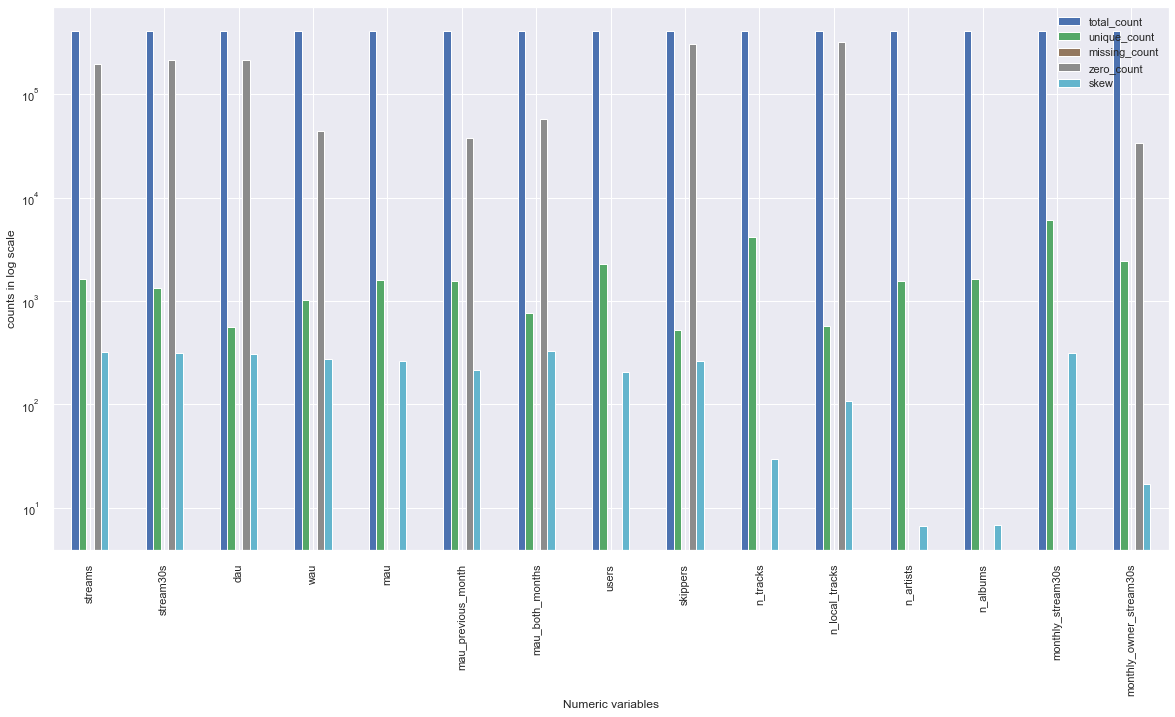

In [46]:
#Vizualizing counts for numeric data
get_stacked_bar_plot(df=get_description(df_playlist,dtype='int'),color_palette =None,fig_size=(20,10),stacked=False,xlabel='Numeric variables',ylabel='Counts in log scale')

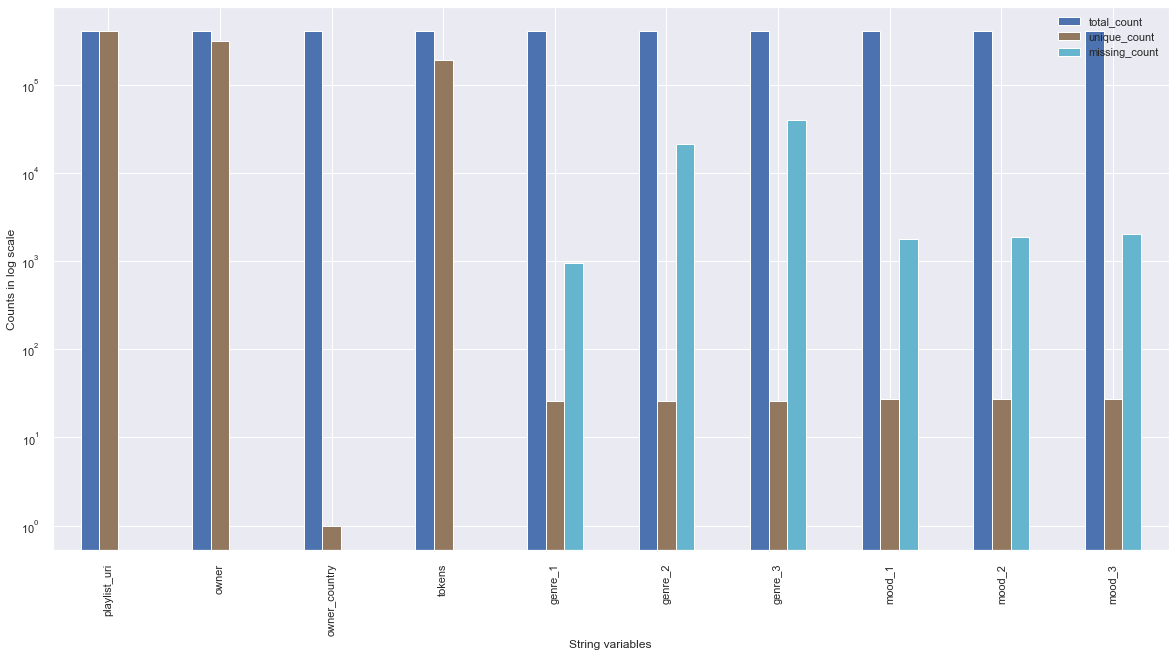

In [47]:
#visualizing counts for categorical data
get_stacked_bar_plot(df=get_description(df_playlist,dtype='object'),color_palette = None,fig_size=(20,10),stacked=False,xlabel='String variables',ylabel='Counts in log scale')

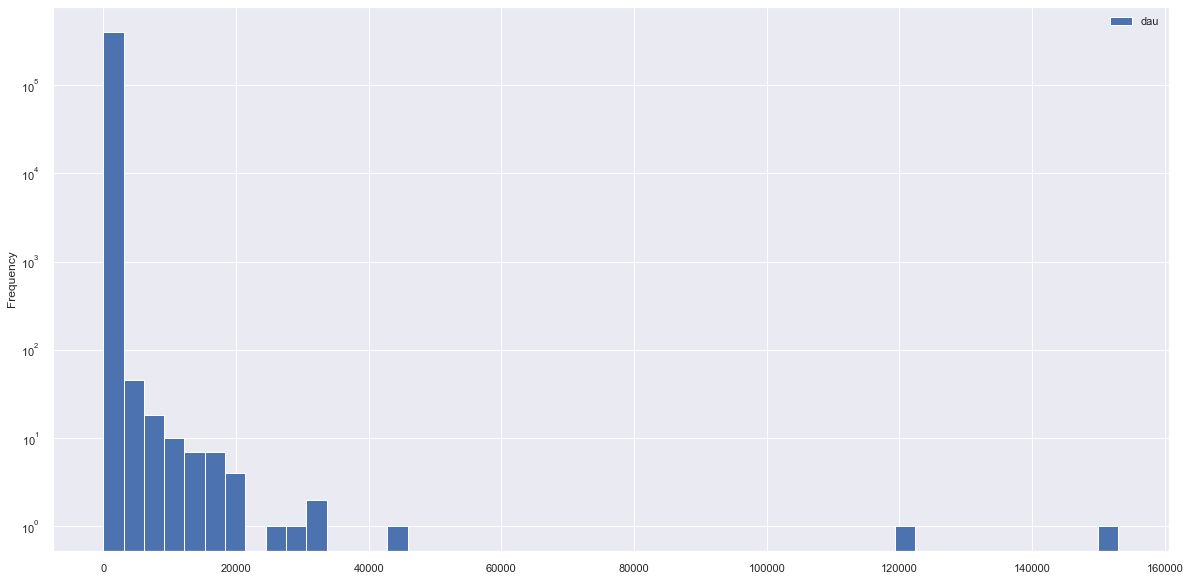

In [10]:
# distribution for numeric variables
get_distribution(df=df_playlist,bins=50,column='dau',fig_size=(20,10),color_palette=None,xlabel='dau',ylabel='Frequency')

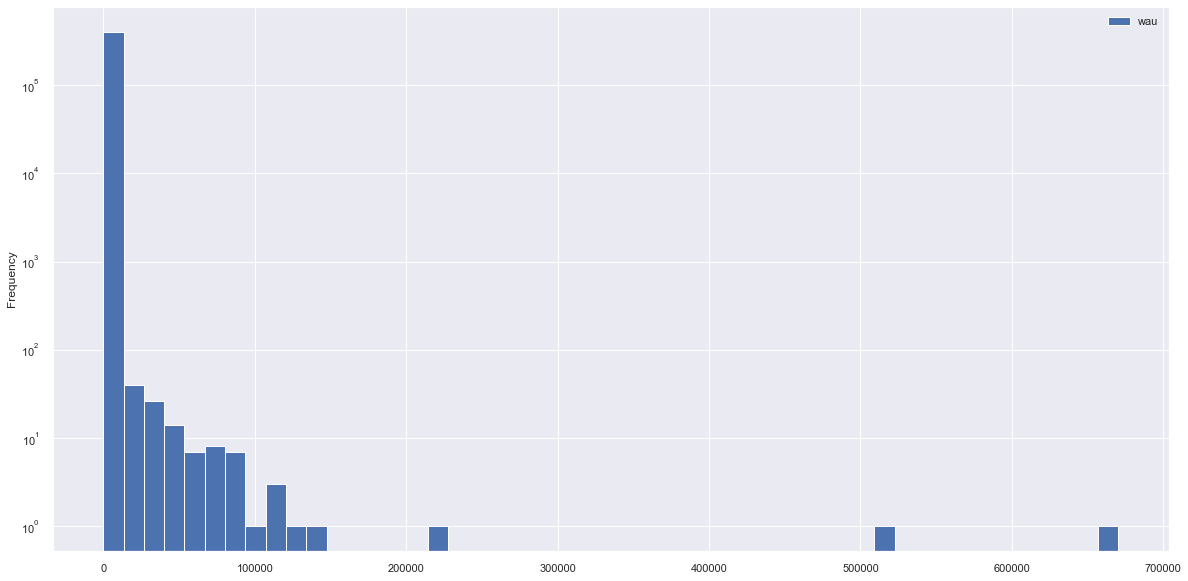

In [11]:
# distribution for numeric variables
get_distribution(df=df_playlist,column='wau',bins=50,fig_size=(20,10),color_palette=None,xlabel='wau',ylabel='Frequency log scale')

* String variables frequency

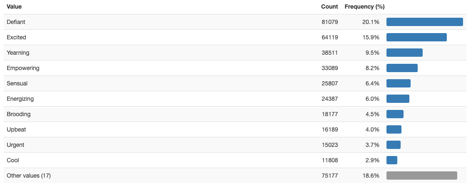

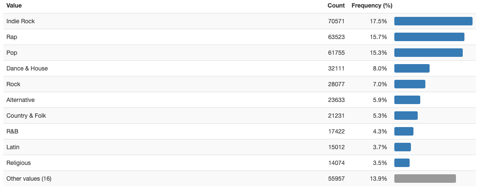

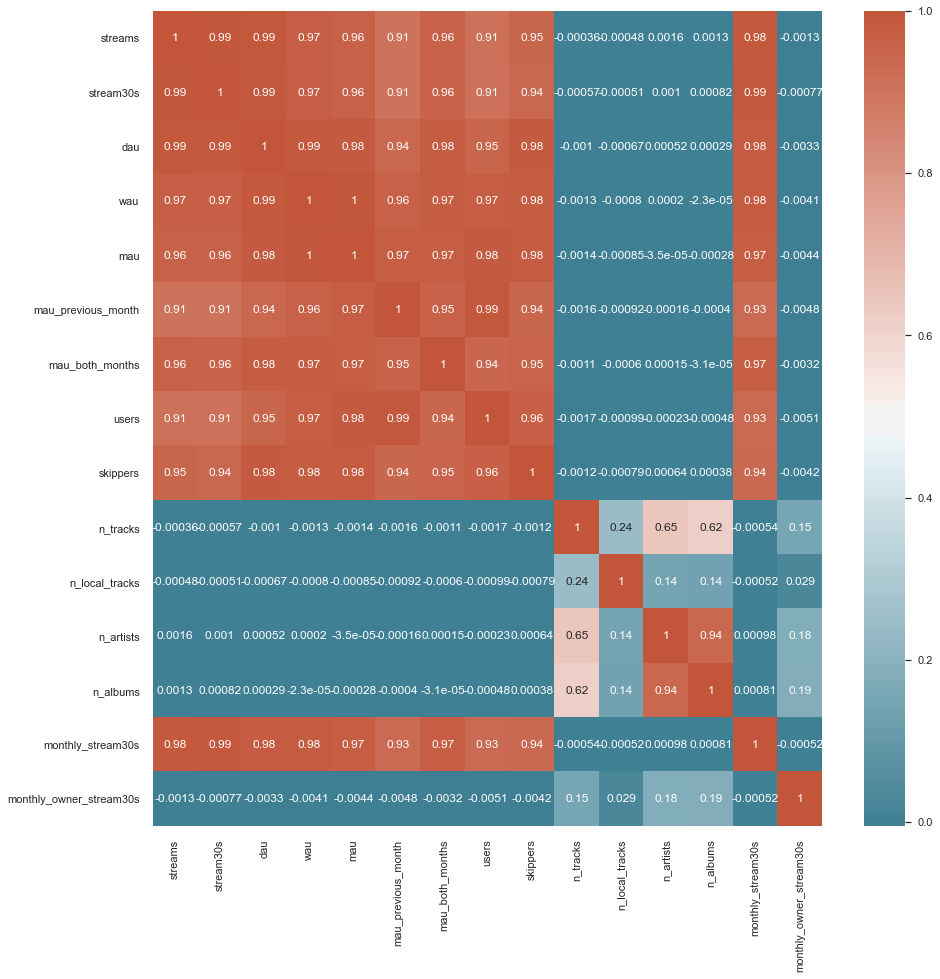

In [12]:
'''
Correlation data
'''
get_corr_matrix(df=df_playlist)

In [13]:
'''
Profile report
'''
#profile_report(df=df_playlist,minimal=True)

'\nProfile report\n'

In [14]:
df_playlist_analysis= df_playlist.copy(deep=True)

#extracting playlist_id from playlist_uri and assigning it back to the dataset
playlist_id= df_playlist_analysis['playlist_uri'].apply(split_strings,args=(':',4))
df_playlist_analysis.insert(loc=0,column='playlist_id',value=playlist_id)

# Defining metrics to measure success
    * dau- Number of Daily Active Users, i.e. users with a stream over 30 seconds from playlist today
    * streams30- Number of streams over 30 seconds from playlist today
    * mau- Number of Monthly Active Users, i.e. users with a stream over 30 seconds from playlist in past month
    * monthly_stream30s- Number of streams over 30 seconds this month


In [15]:
#metric1: DAU
dau_percent = df_playlist_analysis['dau'].quantile(0.75)
df_playlist_analysis['dau_success'] = df_playlist_analysis.apply(lambda x: 1 if x['dau'] > dau_percent else 0, axis=1)
#metric2: stream30s
dstreams_percent = df_playlist_analysis['stream30s'].quantile(0.75)
df_playlist_analysis['dstreams_success'] = df_playlist_analysis.apply(lambda x: 1 if x['stream30s'] > dstreams_percent else 0, axis=1)
#metric3: MAU
mau_percent = df_playlist_analysis['mau'].quantile(0.75)
df_playlist_analysis['mau_success'] = df_playlist_analysis.apply(lambda x: 1 if x['mau'] > mau_percent else 0, axis=1)
#metric4: monthly_stream30s
mstreams_percent = df_playlist_analysis['monthly_stream30s'].quantile(0.75)
df_playlist_analysis['mstreams_success'] = df_playlist_analysis.apply(lambda x: 1 if x['monthly_stream30s'] > mstreams_percent else 0, axis=1)
#Checking if a playlist is successful for all 4 metrics
df_playlist_analysis['successful'] = df_playlist_analysis.apply(lambda x: 1 if (x['dau_success'] == 1 & x['dstreams_success'] == 1 & x['mau_success'] == 1 & x['mstreams_success'] == 1) else 0, axis=1)

In [16]:
df_playlist_analysis.query("successful == 1").shape

(19780, 31)

# We have about 19780 playlists as successful that fall in the top 1/4 th quarter that is around 5% of the playlists 

# mood and genre for successful and unsuccessful playlists

In [17]:
genre_groups = df_playlist_analysis.groupby(['successful','genre_1']).size()
genre_ratios= genre_groups.groupby(level=0).apply(lambda x:x*100/x.sum())
#in percentages
genre_ratios.unstack().T

successful,0,1
genre_1,,
-,0.219247,0.520728
Alternative,5.898547,5.091001
Blues,0.110014,0.161780
Children's,0.372016,1.117290
Classical,0.973706,1.167846
Country & Folk,5.261923,5.293225
Dance & House,8.034183,6.536906
Easy Listening,0.217943,0.460061
Electronica,3.504820,2.952477


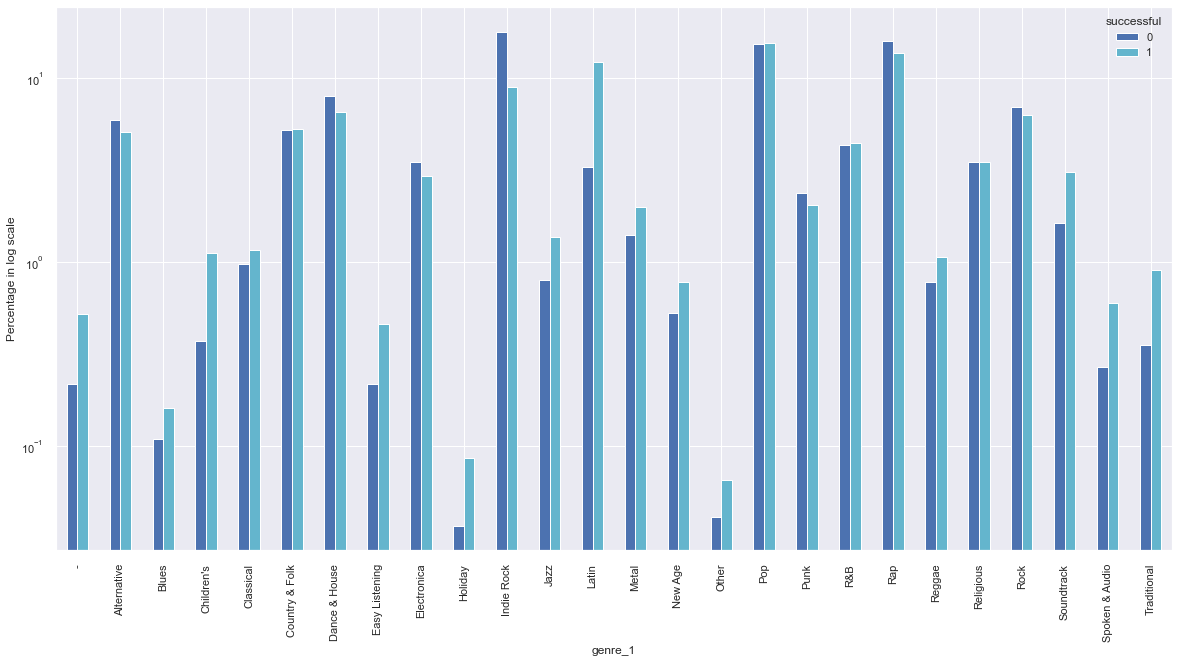

In [145]:
#Vizualizing genre1 across successful and unsuccessful playlists
df = df_playlist_analysis.groupby(['successful','genre_1']).size()
new_df= df.groupby(level=0).apply(lambda x:x*100/x.sum())
sns.set(style='darkgrid')
new_df.unstack().T.plot(kind='bar', stacked=False, colormap=ListedColormap(sns.color_palette()), figsize=(20,10), log=True,legend=True,ylabel='Percentage in log scale')


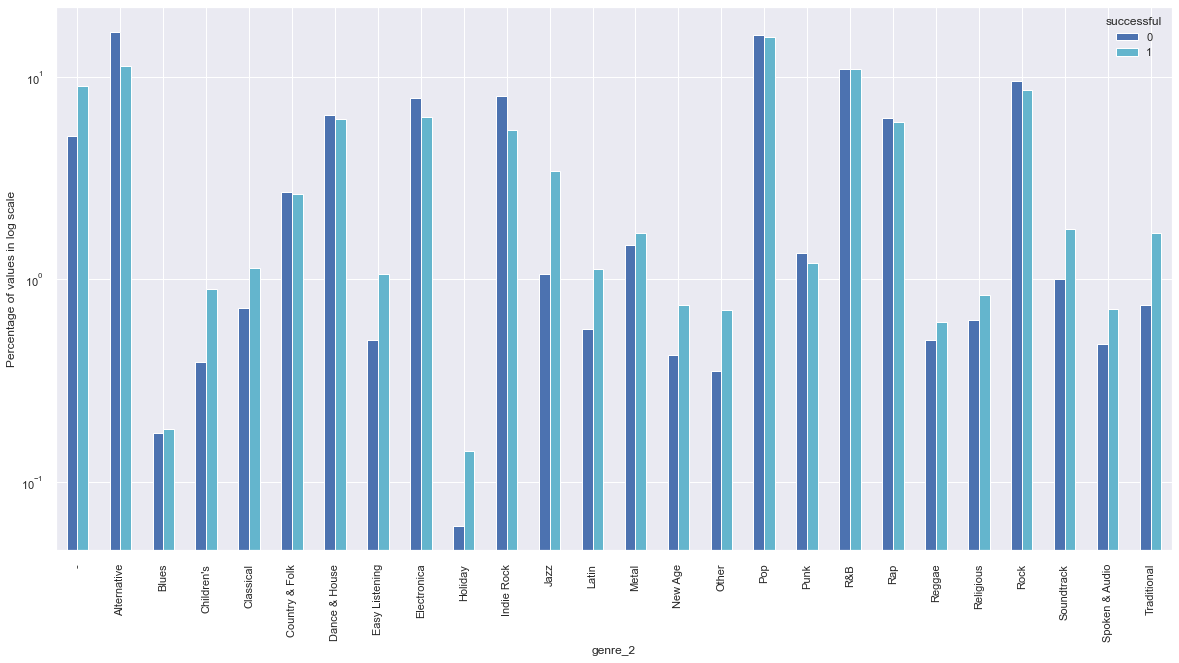

In [49]:
#Vizualizing genre2 across successful and unsuccessful playlists
df = df_playlist_analysis.groupby(['successful','genre_2']).size()
new_df= df.groupby(level=0).apply(lambda x:x*100/x.sum())
sns.set(style='darkgrid')
new_df.unstack().T.plot(kind='bar', stacked=False, colormap=ListedColormap(sns.color_palette()), figsize=(20,10), log=True,legend=True,ylabel='Percentage in log scale')

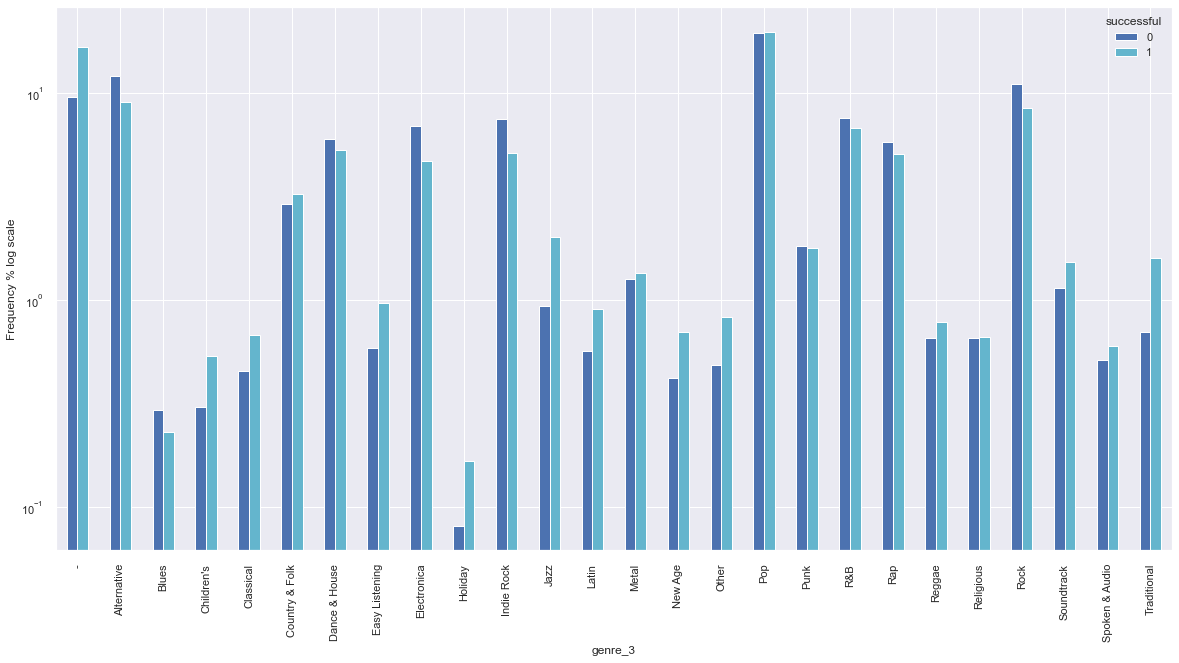

In [20]:
#Vizualizing genre3 across successful and unsuccessful playlists
df = df_playlist_analysis.groupby(['successful','genre_3']).size()
new_df= df.groupby(level=0).apply(lambda x:x*100/x.sum())
sns.set(style='darkgrid')
new_df.unstack().T.plot(kind='bar', stacked=False, colormap=ListedColormap(sns.color_palette()), figsize=(20,10),log=True,legend=True,ylabel='Percentage in log scale')

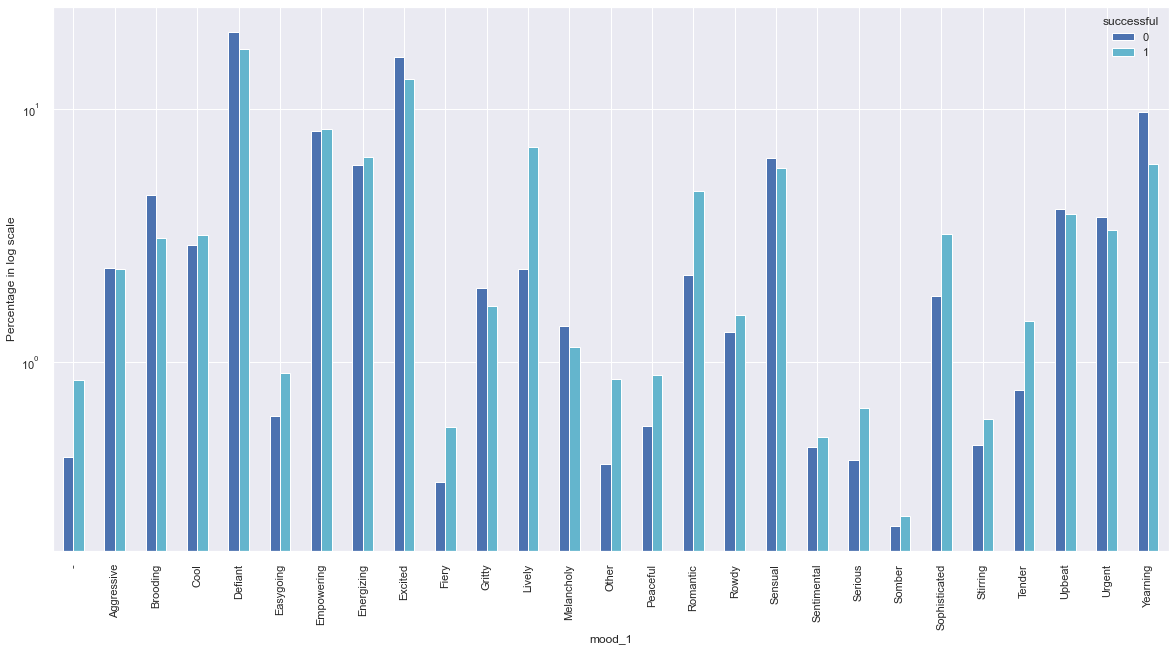

In [146]:
#Vizualizing mood_1 across successful and unsuccessful playlists
df = df_playlist_analysis.groupby(['successful','mood_1']).size()
new_df= df.groupby(level=0).apply(lambda x:x*100/x.sum())
sns.set(style='darkgrid')
new_df.unstack().T.plot(kind='bar', stacked=False, colormap=ListedColormap(sns.color_palette()), figsize=(20,10), log=True,legend=True,ylabel='Percentage in log scale')

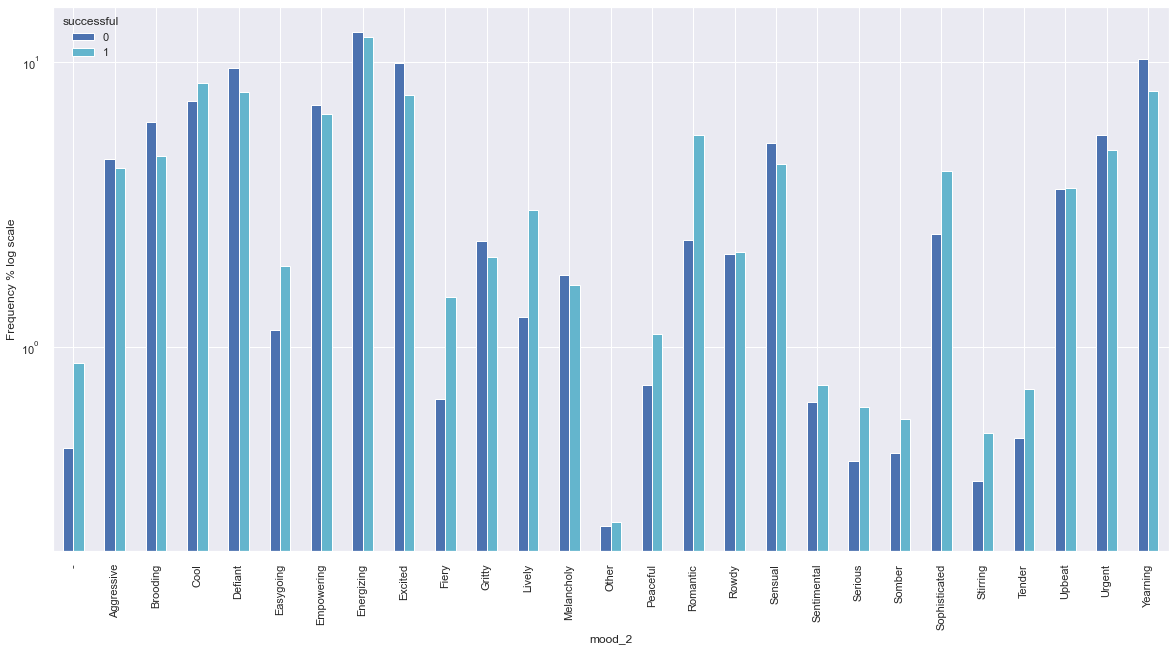

In [22]:
#Vizualizing mood_2 across successful and unsuccessful playlists
df = df_playlist_analysis.groupby(['successful','mood_2']).size()
new_df= df.groupby(level=0).apply(lambda x:x*100/x.sum())
sns.set(style='darkgrid')
new_df.unstack().T.plot(kind='bar', stacked=False, colormap=ListedColormap(sns.color_palette()), figsize=(20,10), log=True,legend=True,ylabel='Frequency % log scale')

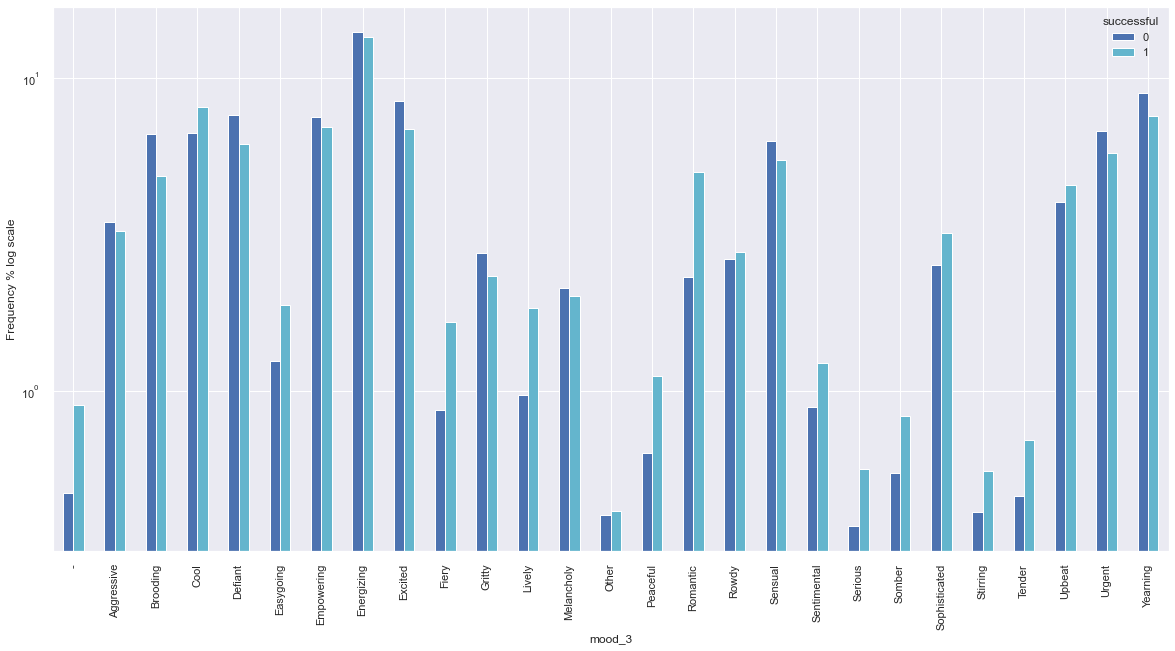

In [23]:
#Vizualizing mood_3 across successful and unsuccessful playlists
df = df_playlist_analysis.groupby(['successful','mood_3']).size()
new_df= df.groupby(level=0).apply(lambda x:x*100/x.sum())
sns.set(style='darkgrid')
new_df.unstack().T.plot(kind='bar', stacked=False, colormap=ListedColormap(sns.color_palette()), figsize=(20,10), log=True,legend=True,ylabel='Frequency % log scale')

# Other features on sucessful and unsucessful playlists

# n_tracks

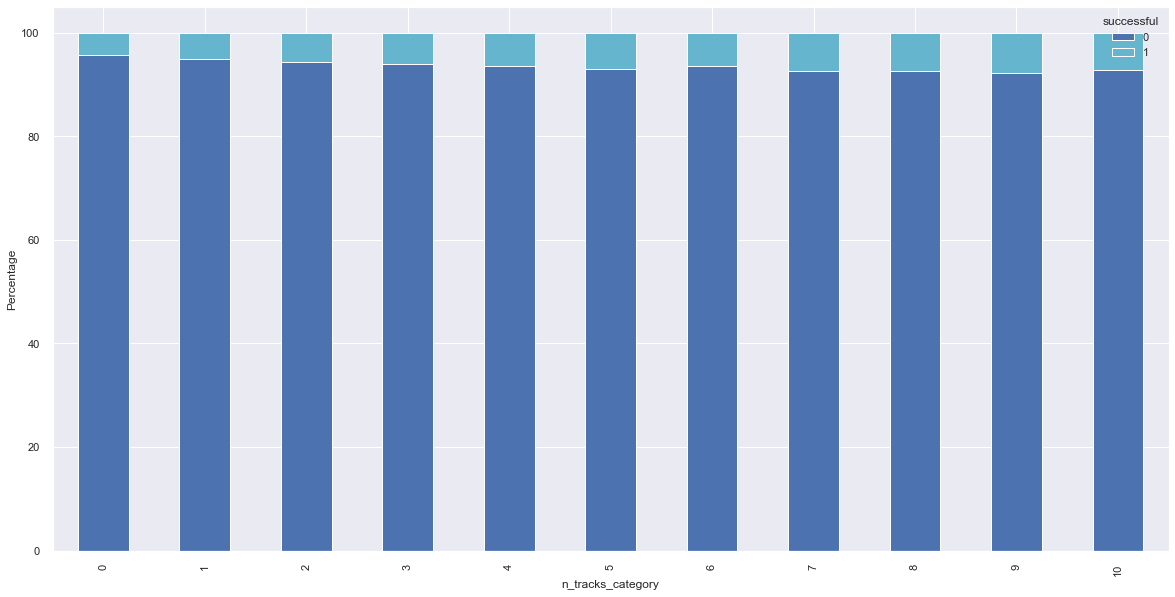

In [53]:
df_playlist_analysis['n_tracks_category'] = df_playlist_analysis.apply(lambda x: x['n_tracks'] // 100 if x['n_tracks'] // 100 < 10 else 10, axis=1)
nTracksGroups = df_playlist_analysis.groupby(['n_tracks_category', 'successful']).size()
#nTracksGroups.unstack().plot(kind='bar', color=['b', 'r'])
nTracksGroupsRatios = nTracksGroups.groupby(level=0).apply(lambda x: x*100/x.sum())
nTracksGroupsRatios.unstack().plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette()),figsize=(20,10),ylabel='Percentage')

# n_albums

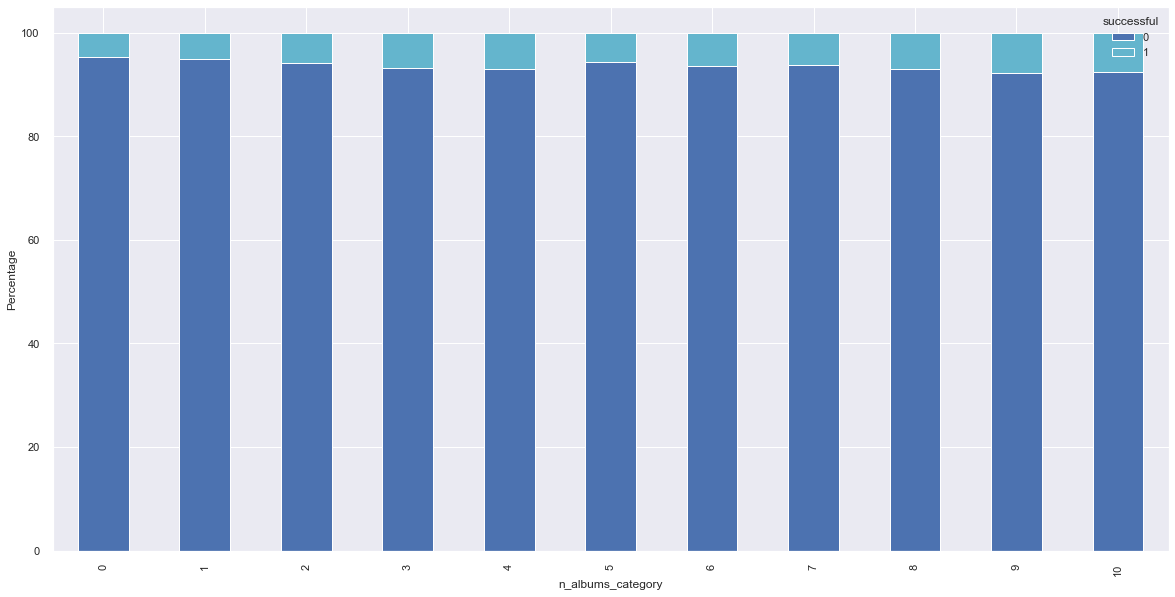

In [54]:
df_playlist_analysis['n_albums_category'] = df_playlist_analysis.apply(lambda x: x['n_albums'] // 100 if x['n_albums'] // 100 < 10 else 10, axis=1)
nAlbumsGroups = df_playlist_analysis.groupby(['n_albums_category', 'successful']).size()
nAlbumsGroupsRatios = nAlbumsGroups.groupby(level=0).apply(lambda x: x*100/x.sum())
nAlbumsGroupsRatios.unstack().plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette()), figsize=(20,10),ylabel='Percentage')

# n_artists

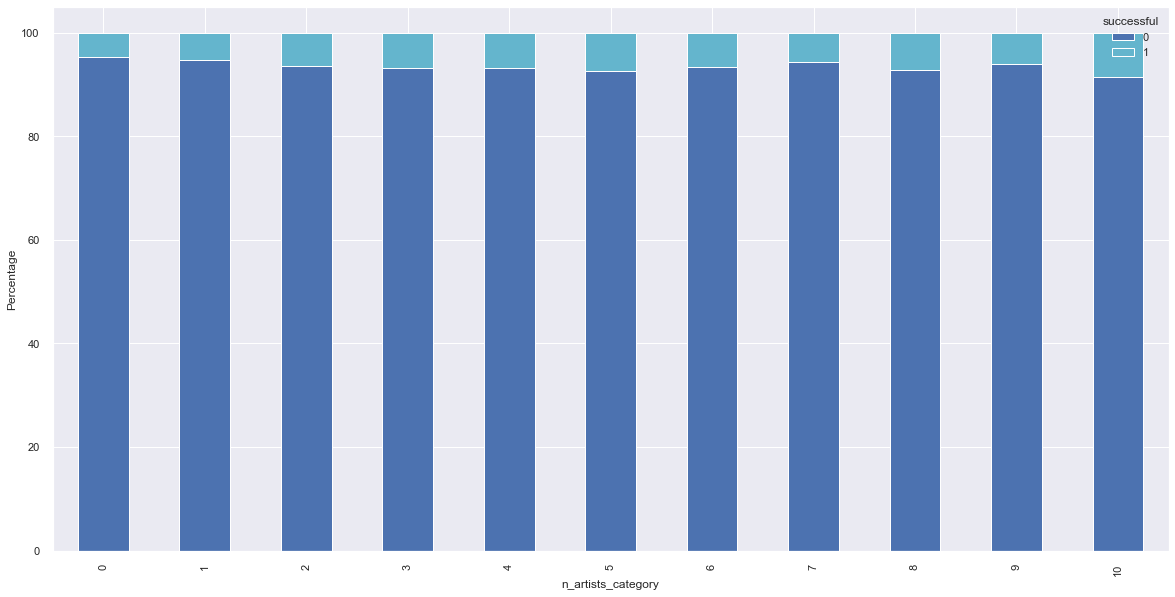

In [55]:
df_playlist_analysis['n_artists_category'] = df_playlist_analysis.apply(lambda x: x['n_artists'] // 100 if x['n_artists'] // 100 < 10 else 10, axis=1)
nArtistsGroups = df_playlist_analysis.groupby(['n_artists_category', 'successful']).size()
nArtistsGroupsRatios = nArtistsGroups.groupby(level=0).apply(lambda x: x*100/x.sum())
nArtistsGroupsRatios.unstack().plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette()), figsize=(20,10),ylabel='Percentage')

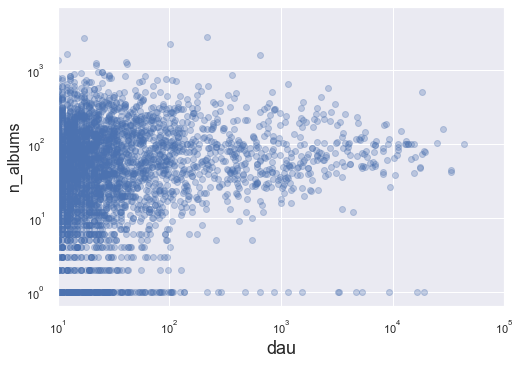

In [178]:
df= df_playlist_analysis.query("successful == 1")

fig = plt.figure()
ax = plt.gca()
#fig.suptitle('dau  n_tracks', fontsize=20)
plt.xlabel('dau', fontsize=18)
plt.ylabel('n_albums', fontsize=16)
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlim(10**1,10**5)
ax.scatter(df['dau'] ,df['n_albums'], alpha=0.3)


plt.grid(True)
pylab.show()


more like normal 

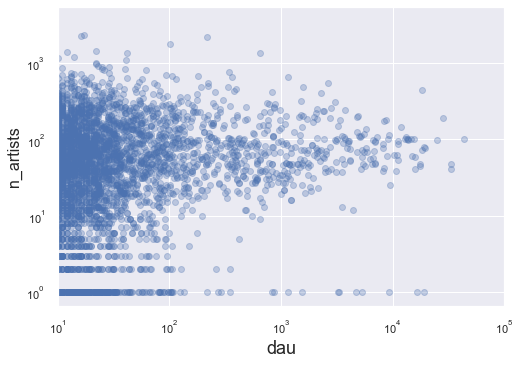

In [179]:
df= df_playlist_analysis.query("successful == 1")

fig = plt.figure()
ax = plt.gca()
#fig.suptitle('dau  n_tracks', fontsize=20)
plt.xlabel('dau', fontsize=18)
plt.ylabel('n_artists', fontsize=16)
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlim(10**1,10**5)
ax.scatter(df['dau'] ,df['n_artists'], alpha=0.3)


plt.grid(True)
pylab.show()



# Vizualyzing playlist tokens for successful playlist

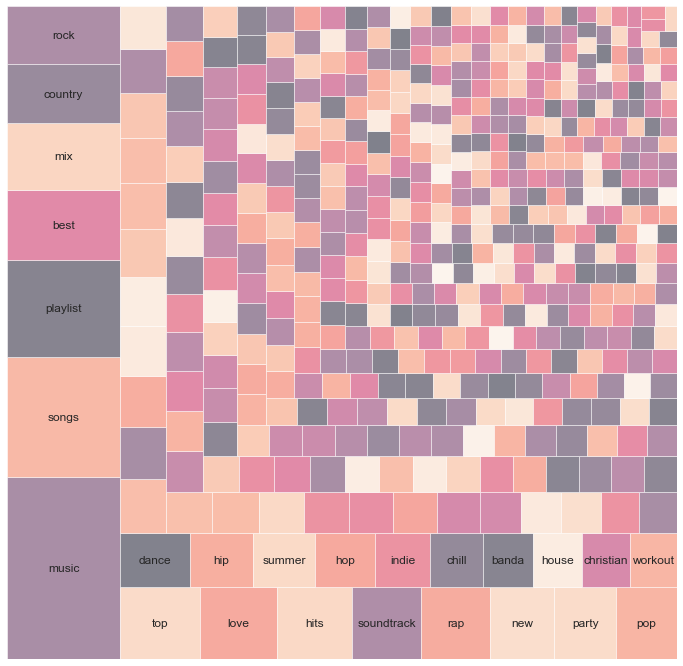

In [27]:
df = df_playlist_analysis.query("successful == 1")['tokens'].apply(split_to_rows).explode().reset_index()
df_without_empty_search= df[df['tokens'] != '']
df_semi_clean= df_without_empty_search['tokens'].str.lstrip().str.rstrip().str.lower().value_counts().to_frame().reset_index()
df_semi_clean.columns= ['tokens','count']
df_semi_clean.sort_values(by=['count'],ascending=False,inplace=True)
get_treemap(df=df_semi_clean ,size='count',label='tokens', alpha= .5)

# Vizualyzing playlist tokens for unsuccessful playlist

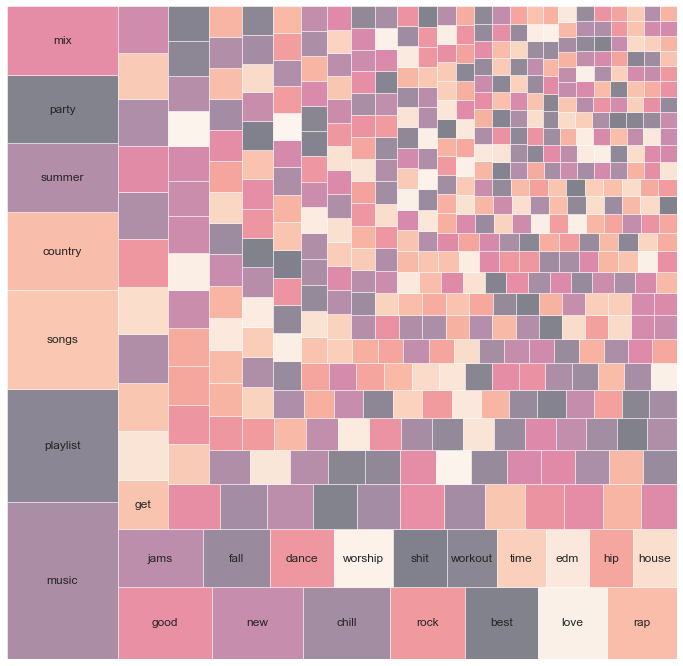

In [28]:
df = df_playlist_analysis.query("successful != 1")['tokens'].apply(split_to_rows).explode().reset_index()
df_without_empty_search= df[df['tokens'] != '']
df_semi_clean= df_without_empty_search['tokens'].str.lstrip().str.rstrip().str.lower().value_counts().to_frame().reset_index()
df_semi_clean.columns= ['tokens','count']
df_semi_clean.sort_values(by=['count'],ascending=False,inplace=True)
get_treemap(df=df_semi_clean ,size='count',label='tokens', alpha= .5)

# Playlist owner for sucessful and unsucesful playlists

In [29]:
df_owner= df_playlist_analysis.query("successful == 1")['owner'].value_counts().to_frame().reset_index().copy(deep=True)
df_owner.columns = ['sucessful_owner_id','num_of_occurrences']
df_owner.query("num_of_occurrences > 1")[:11]

,sucessful_owner_id,num_of_occurrences
0,552c5ee1c8df46c75b6d473d68370189,392
1,ad437dac3689492baba93a66205a2b04,36
2,cb41ca2da57ecfd0381a5f2891735cc2,30
3,64559820ad024637e20047906adabeda,29
4,8eecd7fb330e5217bfbe6c81967150e0,16
5,9984b67a52aef608cdbbf066bd339e70,15
6,46bc904b127f9c0e6031c3f528497e38,15
7,e92ffbf848c7fda8675e7c0ec2b44929,13
8,526da0ac9890dbaa28309705f46364f6,13
9,0dce906b1b58e56c4e274d47066c650c,12


In [30]:
df_owner= df_playlist_analysis.query("successful != 1")['owner'].value_counts().to_frame().reset_index().copy(deep=True)
df_owner.columns = ['unsucessful_owner_id','num_of_occurrences']
df_owner.query("num_of_occurrences > 1")[:11]

,unsucessful_owner_id,num_of_occurrences
0,c126a48e5cd6f4846c457cb6ec435a6f,44
1,1b62d3f6c6d274b8f80612e27d69d01f,43
2,6addee40da677fe898ef1965cb679b15,40
3,0b5a1db0bb23f6395b8ee9d45d5ec45b,40
4,db61a268738eba333294c7a83d624709,36
5,a38a804ea32c5ba94299b4d0181a7871,35
6,5cd51164a6828bc46ff335aa0ed6207a,34
7,e92ffbf848c7fda8675e7c0ec2b44929,30
8,917977c6b19c3862684aa519590d9594,29
9,81fa39edc05e7a7accb26507939b6491,29
